In [1]:
import pandas as pd
import numpy as np

### Data

In [2]:
data1 = pd.read_csv('../../Data/Jeju/201901-202003.csv')
data1 = data1.fillna('')
data2 = pd.read_csv('../../Data/Jeju/202004.csv')
data2 = data2.fillna('')

In [3]:
data = pd.concat([data1, data2])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048114 entries, 0 to 1350321
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ GB


#### 결측 처리

In [5]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 18 사업체총조사

In [6]:
all_jobs_df = pd.read_csv('data/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [7]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [8]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

In [9]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

#### 거래횟수와 이용고객과의 관계 (2019)

In [10]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [11]:
trade_num_2019 = cust_differ(data)

#### 거래횟수와 이용고객과의 관계 (2020)

In [12]:
def cust_differ_2020(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2020만 사용
    melt_plus = melt_plus[melt_plus.year == 2020]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2020만 사용
    melt_minus = melt_minus[melt_minus.year == 2020]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [13]:
trade_num_2020 = cust_differ_2020(data)

In [14]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [15]:
trade_num.loyal = trade_num.loyal.fillna(-999)
trade_num.refund = trade_num.refund.fillna(999)

In [16]:
trade_num

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,999.0
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,999.0
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,999.0
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,-999.0,1,999.0
...,...,...,...,...,...,...
2575,충북,휴양콘도 운영업,202004.0,62.0,4,999.0
2576,대전,여행사업,202001.0,-999.0,1,999.0
2577,대전,여행사업,202002.0,-999.0,2,999.0
2578,대전,여행사업,202003.0,-999.0,3,999.0


#### 추가변수 결합

In [17]:
data.shape

(26048114, 13)

In [18]:
local_percent_df

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,REG_YYMM,LP
0,강원,강릉시,건강보조식품 소매업,201901,0.138432
1,강원,강릉시,골프장 운영업,201901,0.148825
2,강원,강릉시,과실 및 채소 소매업,201901,1.468549
3,강원,강릉시,관광 민예품 및 선물용품 소매업,201901,0.022661
4,강원,강릉시,그외 기타 스포츠시설 운영업,201901,0.003255
...,...,...,...,...,...
124523,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,202004,1.362619
124524,충북,충주시,한식 음식점업,202004,18.402971
124525,충북,충주시,호텔업,202004,0.059226
124526,충북,충주시,화장품 및 방향제 소매업,202004,0.368080


In [19]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [20]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [21]:
grouped.head(5)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0


In [22]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [23]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [24]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630138,2020-04-01,16,202,40,16,1,1,1,77000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630139,2020-04-01,16,202,40,16,2,1,2,92000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630140,2020-04-01,16,202,40,16,3,2,3,193000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630141,2020-04-01,16,202,40,16,4,1,4,86000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0


In [33]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [34]:
train_df = df_num[df_num['REG_YYMM'] <= '2020-01-01']
validation_df = df_num[(df_num['REG_YYMM'] > '2020-01-01') & (df_num['REG_YYMM'] <'2020-04-01')]

In [53]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num # [df_num['REG_YYMM'] >= '2020']
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [54]:
temp.month = 7
temp = pd.concat([df_num[df_num['REG_YYMM'] == '2020-04-01'], temp])

In [55]:
temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

### Light GBM

In [38]:
import lightgbm as lgb

In [39]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019


In [40]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [41]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [42]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [43]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [44]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=2000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),)

[1]	training's rmse: 2.00962	valid_1's rmse: 1.99473
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.9016	valid_1's rmse: 1.88559
[3]	training's rmse: 1.83025	valid_1's rmse: 1.81133
[4]	training's rmse: 1.77923	valid_1's rmse: 1.76064
[5]	training's rmse: 1.75745	valid_1's rmse: 1.74012
[6]	training's rmse: 1.71867	valid_1's rmse: 1.70083
[7]	training's rmse: 1.70553	valid_1's rmse: 1.68972
[8]	training's rmse: 1.67341	valid_1's rmse: 1.65377
[9]	training's rmse: 1.65644	valid_1's rmse: 1.63779
[10]	training's rmse: 1.64989	valid_1's rmse: 1.63512
[11]	training's rmse: 1.63306	valid_1's rmse: 1.6183
[12]	training's rmse: 1.61402	valid_1's rmse: 1.59795
[13]	training's rmse: 1.58615	valid_1's rmse: 1.56545
[14]	training's rmse: 1.56854	valid_1's rmse: 1.54826
[15]	training's rmse: 1.55655	valid_1's rmse: 1.55059
[16]	training's rmse: 1.5486	valid_1's rmse: 1.54306
[17]	training's rmse: 1.52826	valid_1's rmse: 1.52496
[18]	training's rmse: 1.48631	va

[153]	training's rmse: 1.05126	valid_1's rmse: 1.11909
[154]	training's rmse: 1.05056	valid_1's rmse: 1.11853
[155]	training's rmse: 1.04975	valid_1's rmse: 1.11802
[156]	training's rmse: 1.0483	valid_1's rmse: 1.11697
[157]	training's rmse: 1.04682	valid_1's rmse: 1.1158
[158]	training's rmse: 1.04444	valid_1's rmse: 1.1147
[159]	training's rmse: 1.04306	valid_1's rmse: 1.1141
[160]	training's rmse: 1.04258	valid_1's rmse: 1.11364
[161]	training's rmse: 1.04184	valid_1's rmse: 1.11313
[162]	training's rmse: 1.04154	valid_1's rmse: 1.11309
[163]	training's rmse: 1.04083	valid_1's rmse: 1.11231
[164]	training's rmse: 1.04035	valid_1's rmse: 1.11202
[165]	training's rmse: 1.03969	valid_1's rmse: 1.11153
[166]	training's rmse: 1.03911	valid_1's rmse: 1.1112
[167]	training's rmse: 1.03798	valid_1's rmse: 1.11033
[168]	training's rmse: 1.03711	valid_1's rmse: 1.10972
[169]	training's rmse: 1.03601	valid_1's rmse: 1.1096
[170]	training's rmse: 1.03525	valid_1's rmse: 1.10889
[171]	training's

[301]	training's rmse: 0.945915	valid_1's rmse: 1.04371
[302]	training's rmse: 0.945649	valid_1's rmse: 1.04356
[303]	training's rmse: 0.94509	valid_1's rmse: 1.04332
[304]	training's rmse: 0.944642	valid_1's rmse: 1.04297
[305]	training's rmse: 0.944275	valid_1's rmse: 1.04274
[306]	training's rmse: 0.944117	valid_1's rmse: 1.04239
[307]	training's rmse: 0.943934	valid_1's rmse: 1.04224
[308]	training's rmse: 0.943555	valid_1's rmse: 1.04251
[309]	training's rmse: 0.942882	valid_1's rmse: 1.04189
[310]	training's rmse: 0.942295	valid_1's rmse: 1.04166
[311]	training's rmse: 0.941755	valid_1's rmse: 1.04157
[312]	training's rmse: 0.940915	valid_1's rmse: 1.04091
[313]	training's rmse: 0.940577	valid_1's rmse: 1.04073
[314]	training's rmse: 0.93995	valid_1's rmse: 1.04041
[315]	training's rmse: 0.939429	valid_1's rmse: 1.0403
[316]	training's rmse: 0.938475	valid_1's rmse: 1.03948
[317]	training's rmse: 0.938355	valid_1's rmse: 1.03939
[318]	training's rmse: 0.938034	valid_1's rmse: 1.0

[449]	training's rmse: 0.883835	valid_1's rmse: 1.00713
[450]	training's rmse: 0.883333	valid_1's rmse: 1.00688
[451]	training's rmse: 0.883097	valid_1's rmse: 1.00631
[452]	training's rmse: 0.882697	valid_1's rmse: 1.00605
[453]	training's rmse: 0.8824	valid_1's rmse: 1.00592
[454]	training's rmse: 0.882157	valid_1's rmse: 1.00576
[455]	training's rmse: 0.881676	valid_1's rmse: 1.00546
[456]	training's rmse: 0.881215	valid_1's rmse: 1.00506
[457]	training's rmse: 0.881033	valid_1's rmse: 1.00504
[458]	training's rmse: 0.880932	valid_1's rmse: 1.00516
[459]	training's rmse: 0.880747	valid_1's rmse: 1.00507
[460]	training's rmse: 0.880595	valid_1's rmse: 1.00495
[461]	training's rmse: 0.880271	valid_1's rmse: 1.00486
[462]	training's rmse: 0.880104	valid_1's rmse: 1.00478
[463]	training's rmse: 0.879539	valid_1's rmse: 1.00435
[464]	training's rmse: 0.879449	valid_1's rmse: 1.0043
[465]	training's rmse: 0.87935	valid_1's rmse: 1.00427
[466]	training's rmse: 0.879108	valid_1's rmse: 1.00

[595]	training's rmse: 0.846076	valid_1's rmse: 0.986299
[596]	training's rmse: 0.845778	valid_1's rmse: 0.986052
[597]	training's rmse: 0.845621	valid_1's rmse: 0.9859
[598]	training's rmse: 0.845486	valid_1's rmse: 0.985745
[599]	training's rmse: 0.845332	valid_1's rmse: 0.985662
[600]	training's rmse: 0.844877	valid_1's rmse: 0.985316
[601]	training's rmse: 0.844699	valid_1's rmse: 0.985305
[602]	training's rmse: 0.844569	valid_1's rmse: 0.985224
[603]	training's rmse: 0.844496	valid_1's rmse: 0.98518
[604]	training's rmse: 0.844387	valid_1's rmse: 0.985167
[605]	training's rmse: 0.843568	valid_1's rmse: 0.984486
[606]	training's rmse: 0.843286	valid_1's rmse: 0.984297
[607]	training's rmse: 0.843122	valid_1's rmse: 0.984116
[608]	training's rmse: 0.842723	valid_1's rmse: 0.983721
[609]	training's rmse: 0.842558	valid_1's rmse: 0.983639
[610]	training's rmse: 0.842381	valid_1's rmse: 0.983585
[611]	training's rmse: 0.842298	valid_1's rmse: 0.98334
[612]	training's rmse: 0.842224	val

[739]	training's rmse: 0.818723	valid_1's rmse: 0.970779
[740]	training's rmse: 0.818638	valid_1's rmse: 0.970883
[741]	training's rmse: 0.81859	valid_1's rmse: 0.970921
[742]	training's rmse: 0.818377	valid_1's rmse: 0.970709
[743]	training's rmse: 0.81829	valid_1's rmse: 0.970529
[744]	training's rmse: 0.818101	valid_1's rmse: 0.97044
[745]	training's rmse: 0.817994	valid_1's rmse: 0.970429
[746]	training's rmse: 0.817827	valid_1's rmse: 0.970394
[747]	training's rmse: 0.817724	valid_1's rmse: 0.970456
[748]	training's rmse: 0.817613	valid_1's rmse: 0.970475
[749]	training's rmse: 0.817493	valid_1's rmse: 0.970442
[750]	training's rmse: 0.81737	valid_1's rmse: 0.970357
[751]	training's rmse: 0.817322	valid_1's rmse: 0.970333
[752]	training's rmse: 0.817218	valid_1's rmse: 0.970244
[753]	training's rmse: 0.817043	valid_1's rmse: 0.970226
[754]	training's rmse: 0.816839	valid_1's rmse: 0.970048
[755]	training's rmse: 0.816636	valid_1's rmse: 0.969882
[756]	training's rmse: 0.816314	val

[885]	training's rmse: 0.795654	valid_1's rmse: 0.959312
[886]	training's rmse: 0.795522	valid_1's rmse: 0.959348
[887]	training's rmse: 0.79545	valid_1's rmse: 0.959371
[888]	training's rmse: 0.795261	valid_1's rmse: 0.959236
[889]	training's rmse: 0.79519	valid_1's rmse: 0.95917
[890]	training's rmse: 0.795154	valid_1's rmse: 0.959071
[891]	training's rmse: 0.795114	valid_1's rmse: 0.958902
[892]	training's rmse: 0.794977	valid_1's rmse: 0.958727
[893]	training's rmse: 0.794853	valid_1's rmse: 0.958601
[894]	training's rmse: 0.794257	valid_1's rmse: 0.95829
[895]	training's rmse: 0.794188	valid_1's rmse: 0.958281
[896]	training's rmse: 0.794112	valid_1's rmse: 0.958677
[897]	training's rmse: 0.794063	valid_1's rmse: 0.958691
[898]	training's rmse: 0.793957	valid_1's rmse: 0.958694
[899]	training's rmse: 0.793781	valid_1's rmse: 0.958605
[900]	training's rmse: 0.79371	valid_1's rmse: 0.95857
[901]	training's rmse: 0.793363	valid_1's rmse: 0.958341
[902]	training's rmse: 0.793227	valid

[1031]	training's rmse: 0.778268	valid_1's rmse: 0.950967
[1032]	training's rmse: 0.778179	valid_1's rmse: 0.950973
[1033]	training's rmse: 0.778108	valid_1's rmse: 0.950889
[1034]	training's rmse: 0.778057	valid_1's rmse: 0.95086
[1035]	training's rmse: 0.7779	valid_1's rmse: 0.950867
[1036]	training's rmse: 0.777794	valid_1's rmse: 0.950751
[1037]	training's rmse: 0.777553	valid_1's rmse: 0.950668
[1038]	training's rmse: 0.777418	valid_1's rmse: 0.950531
[1039]	training's rmse: 0.777313	valid_1's rmse: 0.9505
[1040]	training's rmse: 0.777142	valid_1's rmse: 0.95047
[1041]	training's rmse: 0.777007	valid_1's rmse: 0.950534
[1042]	training's rmse: 0.776946	valid_1's rmse: 0.950497
[1043]	training's rmse: 0.776873	valid_1's rmse: 0.950486
[1044]	training's rmse: 0.77681	valid_1's rmse: 0.950483
[1045]	training's rmse: 0.776753	valid_1's rmse: 0.950466
[1046]	training's rmse: 0.776681	valid_1's rmse: 0.950245
[1047]	training's rmse: 0.776569	valid_1's rmse: 0.950216
[1048]	training's rms

[1174]	training's rmse: 0.763884	valid_1's rmse: 0.943561
[1175]	training's rmse: 0.763746	valid_1's rmse: 0.943434
[1176]	training's rmse: 0.763703	valid_1's rmse: 0.943388
[1177]	training's rmse: 0.76351	valid_1's rmse: 0.943227
[1178]	training's rmse: 0.763441	valid_1's rmse: 0.94316
[1179]	training's rmse: 0.763378	valid_1's rmse: 0.943124
[1180]	training's rmse: 0.763335	valid_1's rmse: 0.943115
[1181]	training's rmse: 0.763209	valid_1's rmse: 0.943031
[1182]	training's rmse: 0.763042	valid_1's rmse: 0.942841
[1183]	training's rmse: 0.762955	valid_1's rmse: 0.942846
[1184]	training's rmse: 0.762863	valid_1's rmse: 0.942823
[1185]	training's rmse: 0.762627	valid_1's rmse: 0.942691
[1186]	training's rmse: 0.762566	valid_1's rmse: 0.94272
[1187]	training's rmse: 0.762467	valid_1's rmse: 0.942727
[1188]	training's rmse: 0.762403	valid_1's rmse: 0.94268
[1189]	training's rmse: 0.762365	valid_1's rmse: 0.942531
[1190]	training's rmse: 0.762282	valid_1's rmse: 0.942524
[1191]	training's 

[1317]	training's rmse: 0.751426	valid_1's rmse: 0.937325
[1318]	training's rmse: 0.751387	valid_1's rmse: 0.937335
[1319]	training's rmse: 0.751332	valid_1's rmse: 0.93732
[1320]	training's rmse: 0.751289	valid_1's rmse: 0.937315
[1321]	training's rmse: 0.75124	valid_1's rmse: 0.937379
[1322]	training's rmse: 0.751157	valid_1's rmse: 0.937327
[1323]	training's rmse: 0.751132	valid_1's rmse: 0.937251
[1324]	training's rmse: 0.751072	valid_1's rmse: 0.937278
[1325]	training's rmse: 0.750995	valid_1's rmse: 0.937308
[1326]	training's rmse: 0.750967	valid_1's rmse: 0.937369
[1327]	training's rmse: 0.750923	valid_1's rmse: 0.937373
[1328]	training's rmse: 0.750859	valid_1's rmse: 0.937367
[1329]	training's rmse: 0.750702	valid_1's rmse: 0.937278
[1330]	training's rmse: 0.750622	valid_1's rmse: 0.937249
[1331]	training's rmse: 0.750541	valid_1's rmse: 0.937102
[1332]	training's rmse: 0.750483	valid_1's rmse: 0.937085
[1333]	training's rmse: 0.750441	valid_1's rmse: 0.937002
[1334]	training'

[1459]	training's rmse: 0.741049	valid_1's rmse: 0.933345
[1460]	training's rmse: 0.741024	valid_1's rmse: 0.933331
[1461]	training's rmse: 0.740999	valid_1's rmse: 0.933412
[1462]	training's rmse: 0.740943	valid_1's rmse: 0.933316
[1463]	training's rmse: 0.740807	valid_1's rmse: 0.933212
[1464]	training's rmse: 0.740723	valid_1's rmse: 0.933146
[1465]	training's rmse: 0.740676	valid_1's rmse: 0.933127
[1466]	training's rmse: 0.740652	valid_1's rmse: 0.933154
[1467]	training's rmse: 0.740508	valid_1's rmse: 0.932998
[1468]	training's rmse: 0.740443	valid_1's rmse: 0.932939
[1469]	training's rmse: 0.740242	valid_1's rmse: 0.932834
[1470]	training's rmse: 0.740204	valid_1's rmse: 0.932836
[1471]	training's rmse: 0.740174	valid_1's rmse: 0.932844
[1472]	training's rmse: 0.740125	valid_1's rmse: 0.932726
[1473]	training's rmse: 0.740067	valid_1's rmse: 0.932726
[1474]	training's rmse: 0.739958	valid_1's rmse: 0.932685
[1475]	training's rmse: 0.739839	valid_1's rmse: 0.932603
[1476]	trainin

[1602]	training's rmse: 0.731737	valid_1's rmse: 0.929457
[1603]	training's rmse: 0.731709	valid_1's rmse: 0.929452
[1604]	training's rmse: 0.731621	valid_1's rmse: 0.92933
[1605]	training's rmse: 0.731526	valid_1's rmse: 0.929312
[1606]	training's rmse: 0.73143	valid_1's rmse: 0.929259
[1607]	training's rmse: 0.731336	valid_1's rmse: 0.929216
[1608]	training's rmse: 0.731304	valid_1's rmse: 0.929213
[1609]	training's rmse: 0.731275	valid_1's rmse: 0.92923
[1610]	training's rmse: 0.731253	valid_1's rmse: 0.929235
[1611]	training's rmse: 0.731146	valid_1's rmse: 0.929216
[1612]	training's rmse: 0.731105	valid_1's rmse: 0.92918
[1613]	training's rmse: 0.731051	valid_1's rmse: 0.929159
[1614]	training's rmse: 0.73096	valid_1's rmse: 0.929196
[1615]	training's rmse: 0.730842	valid_1's rmse: 0.929128
[1616]	training's rmse: 0.730791	valid_1's rmse: 0.929233
[1617]	training's rmse: 0.730679	valid_1's rmse: 0.929248
[1618]	training's rmse: 0.730622	valid_1's rmse: 0.929269
[1619]	training's r

[1744]	training's rmse: 0.722986	valid_1's rmse: 0.926209
[1745]	training's rmse: 0.722958	valid_1's rmse: 0.926192
[1746]	training's rmse: 0.722914	valid_1's rmse: 0.926182
[1747]	training's rmse: 0.722846	valid_1's rmse: 0.926132
[1748]	training's rmse: 0.722761	valid_1's rmse: 0.926088
[1749]	training's rmse: 0.72268	valid_1's rmse: 0.925999
[1750]	training's rmse: 0.722642	valid_1's rmse: 0.926083
[1751]	training's rmse: 0.722581	valid_1's rmse: 0.926032
[1752]	training's rmse: 0.722548	valid_1's rmse: 0.925987
[1753]	training's rmse: 0.722485	valid_1's rmse: 0.925938
[1754]	training's rmse: 0.72246	valid_1's rmse: 0.925944
[1755]	training's rmse: 0.722435	valid_1's rmse: 0.92587
[1756]	training's rmse: 0.722305	valid_1's rmse: 0.92587
[1757]	training's rmse: 0.722222	valid_1's rmse: 0.925886
[1758]	training's rmse: 0.722161	valid_1's rmse: 0.925844
[1759]	training's rmse: 0.722082	valid_1's rmse: 0.925796
[1760]	training's rmse: 0.722026	valid_1's rmse: 0.925786
[1761]	training's 

[1886]	training's rmse: 0.715548	valid_1's rmse: 0.923911
[1887]	training's rmse: 0.715502	valid_1's rmse: 0.923901
[1888]	training's rmse: 0.715476	valid_1's rmse: 0.923903
[1889]	training's rmse: 0.715428	valid_1's rmse: 0.923861
[1890]	training's rmse: 0.715403	valid_1's rmse: 0.923835
[1891]	training's rmse: 0.715364	valid_1's rmse: 0.924066
[1892]	training's rmse: 0.715342	valid_1's rmse: 0.924083
[1893]	training's rmse: 0.715313	valid_1's rmse: 0.924064
[1894]	training's rmse: 0.715255	valid_1's rmse: 0.923999
[1895]	training's rmse: 0.715215	valid_1's rmse: 0.923962
[1896]	training's rmse: 0.715161	valid_1's rmse: 0.924055
[1897]	training's rmse: 0.715132	valid_1's rmse: 0.924101
[1898]	training's rmse: 0.715106	valid_1's rmse: 0.924092
[1899]	training's rmse: 0.715074	valid_1's rmse: 0.923852
[1900]	training's rmse: 0.715029	valid_1's rmse: 0.923858
[1901]	training's rmse: 0.714974	valid_1's rmse: 0.923817
[1902]	training's rmse: 0.714934	valid_1's rmse: 0.92383
[1903]	training

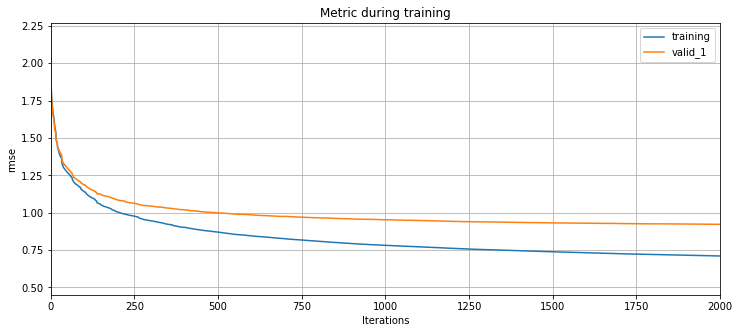

In [45]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

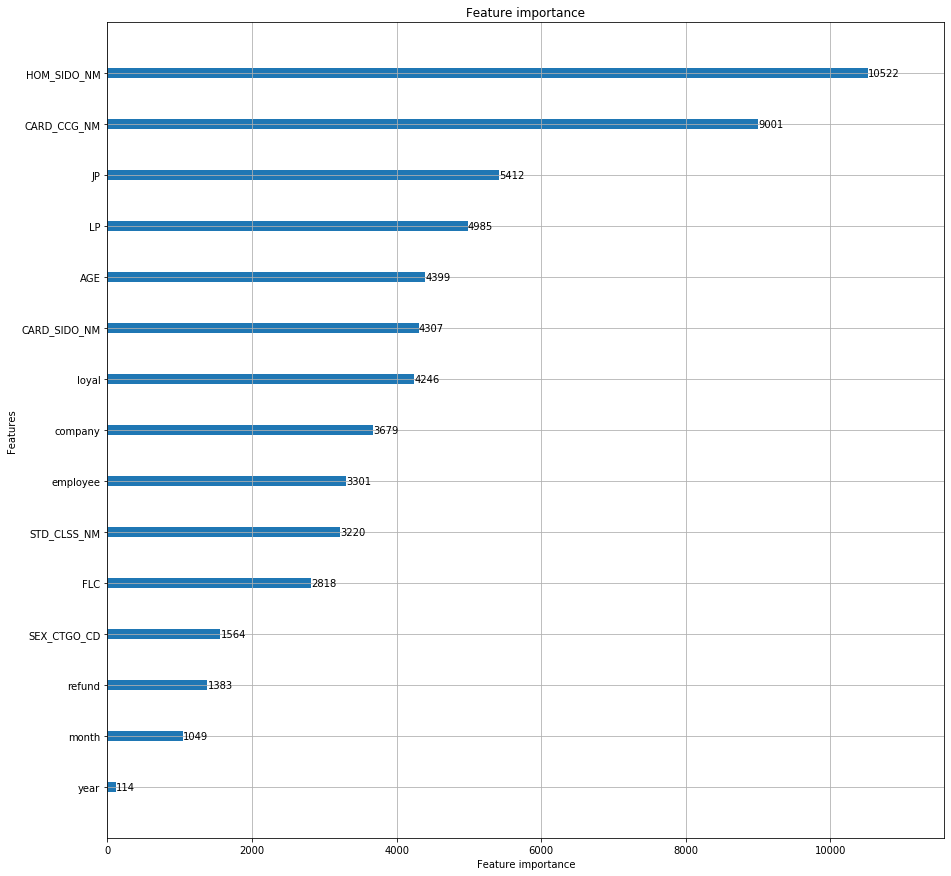

In [46]:
lgb.plot_importance(model, figsize=(15,15))

In [56]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [57]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [58]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

C:\Users\lonj7\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1108: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,9.082982e+07
1,202004,강원,골프장 운영업,5.787078e+09
2,202004,강원,과실 및 채소 소매업,1.281682e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.412818e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [59]:
submission.to_csv('submission/1.csv', encoding='utf-8-sig')

#### 4월 데이터 없이

In [62]:
# 4, 7월 데이터 = 2020년의 평균값을 사용

temp1 = df_num[df_num['REG_YYMM'] >= '2020']
temp1 = temp1.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [67]:
temp2 = temp1.copy()
temp1.month = 4
temp2.month = 7

In [68]:
temp = pd.concat([temp1, temp2])

In [69]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,1,2,1,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
1,0,4,0,0,2,1,2,263.0,399.0,0.108962,0.238864,71.000000,4,-33.666667,2020.0
2,0,4,0,0,2,2,2,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
3,0,4,0,0,3,1,3,263.0,399.0,0.117430,0.265927,77.750000,4,-29.750000,2020.0
4,0,4,0,0,3,1,4,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430404,16,202,40,16,3,2,3,11.0,492.0,0.033359,0.056592,585.000000,7,329.666667,2020.0
430405,16,202,40,16,4,1,4,11.0,492.0,0.026140,0.045117,455.500000,7,497.000000,2020.0
430406,16,202,40,16,4,2,4,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0
430407,16,202,40,16,5,1,5,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0


In [70]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [71]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [72]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.to_csv('submission/submission lgbm 0728 valid Jan_regression_re_re_non April.csv', encoding='utf-8-sig')

#### 2020 4월 데이터 = 2020 3월데이터

In [96]:
# 4월 데이터 = 2020년 3월 데이터 사용
# 7월 데이터 = 2020년의 평균값을 사용

temp1 = df_num[df_num['REG_YYMM'] == '2020-03-01']
temp1 = temp1.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()
temp2 = df_num[df_num['REG_YYMM'] >= '2020-01-01']
temp2 = temp2.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [94]:
temp1.month = 4
temp2.month = 7

temp = pd.concat([temp1, temp2])

In [97]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,2,1,2,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
1,0,4,0,0,3,1,3,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
2,0,4,0,0,3,2,3,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
3,0,4,0,0,4,1,4,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
4,0,4,0,0,4,2,4,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430404,16,202,40,16,3,2,3,11.0,492.0,0.033359,0.056592,585.000000,7,329.666667,2020.0
430405,16,202,40,16,4,1,4,11.0,492.0,0.026140,0.045117,455.500000,7,497.000000,2020.0
430406,16,202,40,16,4,2,4,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0
430407,16,202,40,16,5,1,5,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0


In [98]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [99]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [100]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.to_csv('submission/submission lgbm 0728 valid Jan_regression_re_re_non April_March.csv', encoding='utf-8-sig')